In [1]:
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')           
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras

input_shape = (28, 28, 1)
num_classes = 10
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128

In [15]:
print('\nLoading MNIST')

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_train = x_train.astype(np.float32) / 255
x_test = np.expand_dims(x_test, -1)
x_test = x_test.astype(np.float32) / 255

mnist_twos = x_train[np.where(y_train == 2)][:10]

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nSpliting data')

ind = np.random.permutation(x_train.shape[0])
x_train, y_train = x_train[ind], y_train[ind]
n = int(x_train.shape[0] * (1-VALIDATION_SPLIT))
x_train = x_train[:n]
y_train = y_train[:n]
x_val = x_train[n:]
y_val = y_train[n:]


Loading MNIST

Spliting data


In [3]:
print('\nConstructing model')
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape = input_shape)
    x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=128, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    outputs = keras.layers.Dense(units=num_classes)(x)
    #outputs = keras.layers.Activation('relu')
    return keras.Model(inputs, outputs)


Constructing model


In [4]:
model = make_model(input_shape, num_classes)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print('\nTraining model')
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=5, validation_data=(x_val, y_val))


Training model
Epoch 1/5
422/422 [==============================] - 56s 132ms/step - loss: 0.2447 - accuracy: 0.9253
Epoch 2/5
422/422 [==============================] - 54s 129ms/step - loss: 0.0663 - accuracy: 0.9796
Epoch 3/5
422/422 [==============================] - 55s 129ms/step - loss: 0.0459 - accuracy: 0.9860
Epoch 4/5
422/422 [==============================] - 54s 129ms/step - loss: 0.0366 - accuracy: 0.9892
Epoch 5/5
422/422 [==============================] - 54s 129ms/step - loss: 0.0297 - accuracy: 0.9906


In [89]:
def saliency_map(X, dtdx, dodx, eps, cmin, cmax):
  """
  Saliency map function that returns score for each input dimension.
  """
  # Check initial conditions.
  c1 = tf.logical_or(eps < 0, X < cmax)
  c2 = tf.logical_or(eps > 0, X > cmin)
  
  # Check saliency map conditions.
  c3 = dtdx >= 0
  c4 = dodx <= 0
  
  # Get 1D score by doing logical AND between conditions.
  cond = tf.cast(tf.reduce_all([c1, c2, c3, c4], axis=0),dtype=tf.float32)
  
  score = cond * (dtdx * tf.abs(dodx))
  
  # Return score for each pixel
  score = tf.reshape(score, shape=[1, 784])
  
  return score

In [90]:
def jacobian_matrix(x, n_class):
  """
  Calculate jacobian of logits wrt input.
  """
  
  #print("jacobian_matrix", x.shape)
  x = tf.Variable(x)
  j = []
  for i in range(n_class):
    with tf.GradientTape() as gtape:
      gtape.watch(x)
      y_ = model(x)[0][i]
    
    if(i == 0):
      j.append(gtape.gradient(y_,x))
      #print(j)
    else: 
      j.append(gtape.gradient(y_,x))

  tf_matrix = j[0]
  for i in range(1,10):
    tf_matrix = tf.concat([tf_matrix, j[i]],axis = 0)
  return tf_matrix
  '''  
    if(i == 0):
      j = gtape.gradient(y_,x)
      print(gtape.gradient(y_,x))
    else: 
      j.concat([j,gtape.gradient(y[i],x)],axis = 0)

  with tf.GradientTape as gtape:
    for i in range(n_class):
        if i==0:
            j = gtape.gradient(y[i], x)
        else:
            j = tf.concat([j, gtape.gradient(y[i], x)],axis=0)
  '''
  #return j

In [91]:
def jsma(X_adv, target_y, eps, cmin=0.0, cmax=1.0):
  
  """
  Implementation of JSMA method to generate adversarial images.
  """
  #print("jsma => " , X_adv.shape)
  # Get model logits and probs for the input.
  logits = model.predict(np.expand_dims(X_adv,axis = 0))
  
  # Get model prediction for inputs.
  y_ind = np.argmax(logits)
  
  # Calculate jacobian matrix of logits wrt to input.
  jacobian = jacobian_matrix(np.expand_dims(X_adv,axis = 0), 10)

  # Get the gradient of logits wrt to prediction and target.
  grad_input, grad_target = jacobian[y_ind], jacobian[target_y]
  grad_other = grad_input - grad_target
  
  # Compute saliency score for each dimension.
  score = saliency_map(X_adv, grad_target, grad_other, eps, cmin, cmax)

  # Select dimension of input and apply epsilon value.
  idx = tf.argmax(score, axis=1)
  pert = tf.one_hot(idx, 784, on_value=eps, off_value=0.0)
  pert = tf.reshape(pert, shape=tf.shape(X_adv))

  X_adv = tf.clip_by_value(X_adv + pert, cmin, cmax)

  return X_adv, pert

In [100]:
def generate_jsma(X, target, eps=1.0, epochs=50):
  """
  Run JSMA on input image for `epochs` number of times.
  """
  print("lala")
  #tf.reset_default_graph()
  #tf.set_random_seed(42)
  
  # Placeholder for single image.
  #X_p = tf.placeholder(shape=[28, 28, 1], dtype=tf.float32)
  
  # Op for one iteration of jsma.
  adv_op,_ = jsma(X, target_y=target,eps=eps)

  digit = X.reshape(28,28,1)

  for i in range(1,epochs):
    digit,pert_iter = jsma(digit,target,eps)
  pert = digit - X
  
  tf.reshape(digit,(28,28))
  tf.reshape(pert,(28,28))
  return digit, pert
'''
  with tf.Session() as sess:
    tf.train.Saver().restore(sess, "model.ckpt")
    for i in range(epochs):
      
      digit, pert_iter = sess.run(adv_op, {X_p: digit})
  '''   




'\n  with tf.Session() as sess:\n    tf.train.Saver().restore(sess, "model.ckpt")\n    for i in range(epochs):\n      \n      digit, pert_iter = sess.run(adv_op, {X_p: digit})\n  '

In [19]:
print(mnist_twos.shape)

(10, 28, 28, 1)


In [113]:
advs_jsma, perts_jsma = [], []
for imgs in mnist_twos:
  #print(imgs.shape)
  digit,pert = generate_jsma(
                        imgs,
                        target=6,
                        eps=1.0,
                        epochs=100)
  advs_jsma.append(digit)
  perts_jsma.append(pert)

lala
lala
lala
lala
lala
lala
lala
lala
lala
lala


In [55]:
x = x_train[0]
print(np.expand_dims(x,axis = 0).shape)
print(model(np.expand_dims(x,axis = 0)))
y = np.array([1,1])
mat = jacobian_matrix(y,np.expand_dims(x,axis = 0),10)
print(mat.shape)


(1, 28, 28, 1)
tf.Tensor(
[[ 1.0818776 -3.505971  -4.2537713 -4.7047267 13.570954  -2.2810957
   1.6915368  1.3996876 -3.131057   3.7082984]], shape=(1, 10), dtype=float32)
jacobian_matrix (1, 28, 28, 1) (2,)
(10, 28, 28, 1)


In [76]:
def plot_adversarials(origs, perturbs, advs , orig_preds, orig_probs, adv_probs, adv_preds, eps):
  """
  Function to plot original input, perturbation and adversarial inputs.
  """
  fig, axes = plt.subplots(ncols=3, nrows=10, figsize=(18,18))

  for i in range(10):

      confidence = str(round(orig_probs[i],2))
      pixels = origs[i].reshape((28, 28))
      axes[i][0].imshow(pixels, cmap='gray')
      axes[i][0].set_axis_off()
      title = 'Original\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
      axes[i][0].set_title(title.format(orig_preds[i], confidence))

      pixels = perturbs[i].reshape((28, 28))
      axes[i][1].imshow(pixels, cmap='gray')
      axes[i][1].set_axis_off()
      title = 'Perturbations\n Epsilon: {}' if i==0 else 'Epsilon: {}'
      axes[i][1].set_title(title.format(eps))

      confidence = str(round(adv_probs[i],2))
      pixels = advs[i].reshape((28, 28))
      axes[i][2].imshow(pixels, cmap='gray')
      axes[i][2].set_axis_off()
      title = 'Adversarial\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
      axes[i][2].set_title(title.format(
          adv_preds[i], confidence))

#   plt.subplots_adjust(wspace=0.1, hspace=0.9)
#   fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
  plt.show()


[ 2.8710966 -7.814224   4.856492  -4.0816364  4.116711  -2.1451662
  7.33809   -8.50726    6.927385  -1.7684724]
[[-1.682758   -2.3387609  16.272118   -0.19573632 -3.5396655  -7.654407
  -5.957539    1.7568089   2.9967253  -3.9455683 ]]
(28, 28, 1)


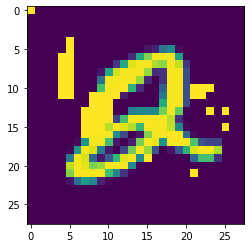

In [117]:
preds_jsma = model.predict(np.array(advs_jsma).reshape(10,28,28,1))
print(preds_jsma[0])
print(model.predict(np.expand_dims(mnist_twos[0],axis = 0)))
plt.imshow(mnist_twos[0,:,:,0])
#advs_jsma = np.array(advs_jsma[0])
print(advs_jsma[0].shape)

plt.imshow(advs_jsma[0][:,:,0])
